# Model fitting 4: Only Synchrotron

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [3]:
print(test_SEDs[1])
data=Data.from_file(test_SEDs[1])


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv



***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2



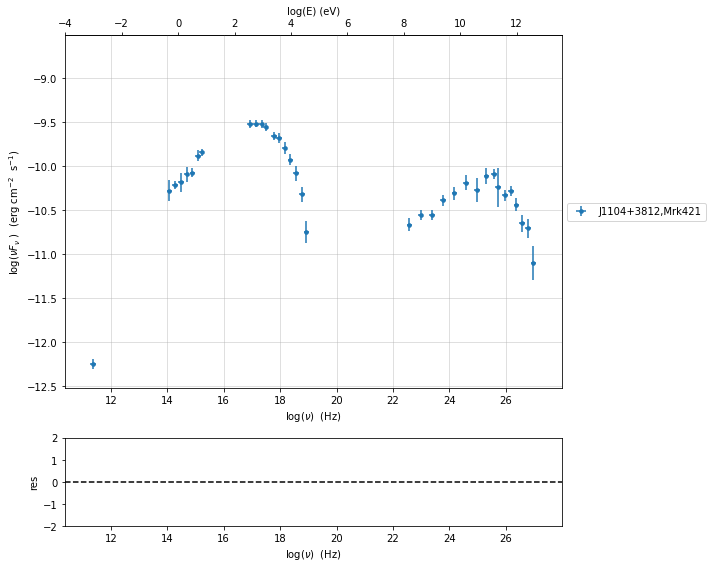

In [4]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [5]:
sed_data.save('Mrk_401.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



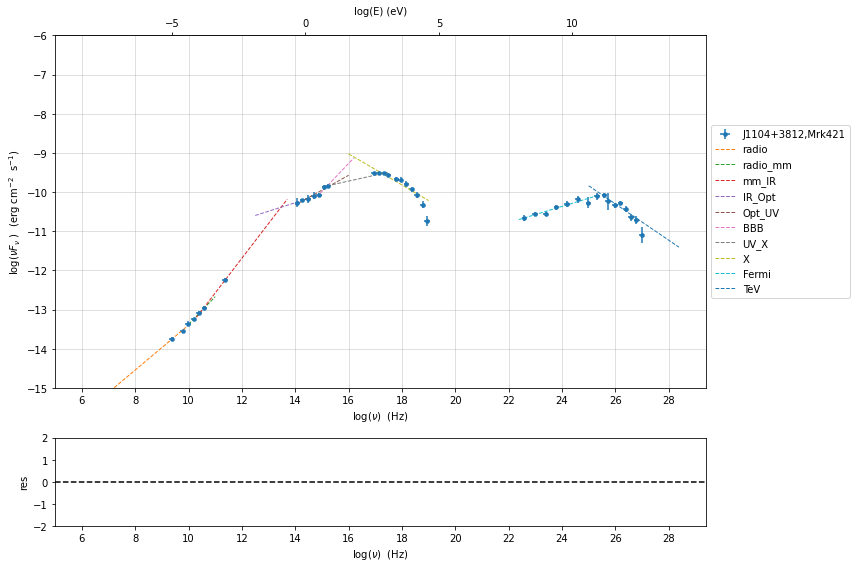

In [6]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

### Sed shaper

In [7]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10., 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.545300e-01,-1.545300e-01,9.534795e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.023245e-02,-1.023245e-02,1.433073e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.672267e+01,1.672267e+01,4.139942e-02,--,1.667039e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.491659e+00,-9.491659e+00,2.515285e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.672267e+01 (err=+4.139942e-02)  nuFnu_p=-9.491659e+00 (err=+2.515285e-02) curv.=-1.545300e-01 (err=+9.534795e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-2.098186e-01,-2.098186e-01,3.133100e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.661867e-02,-4.661867e-02,2.178435e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.524926e+01,2.524926e+01,1.147802e-01,--,2.529412e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.011085e+01,-1.011085e+01,3.498963e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.524926e+01 (err=+1.147802e-01)  nuFnu_p=-1.011085e+01 (err=+3.498963e-02) curv.=-2.098186e-01 (err=+3.133100e-02)



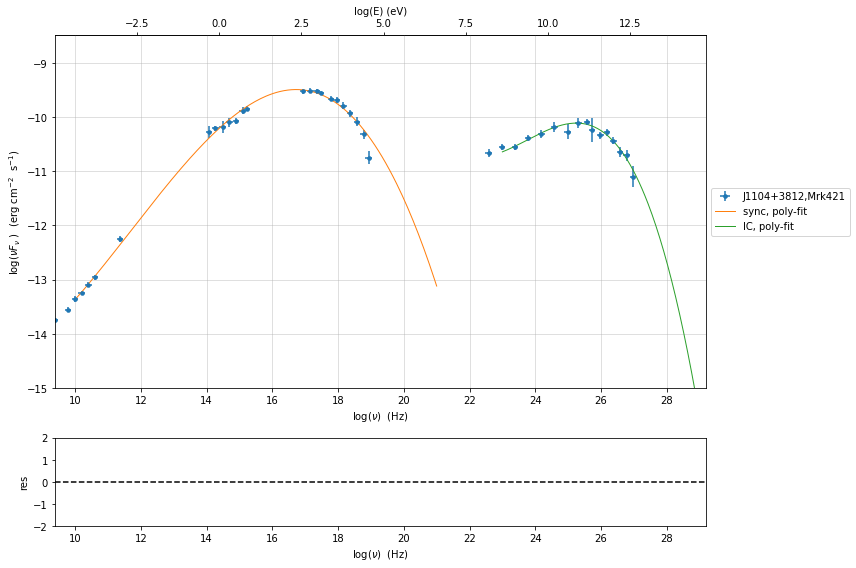

In [8]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

### Model constraining

In [9]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060843e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


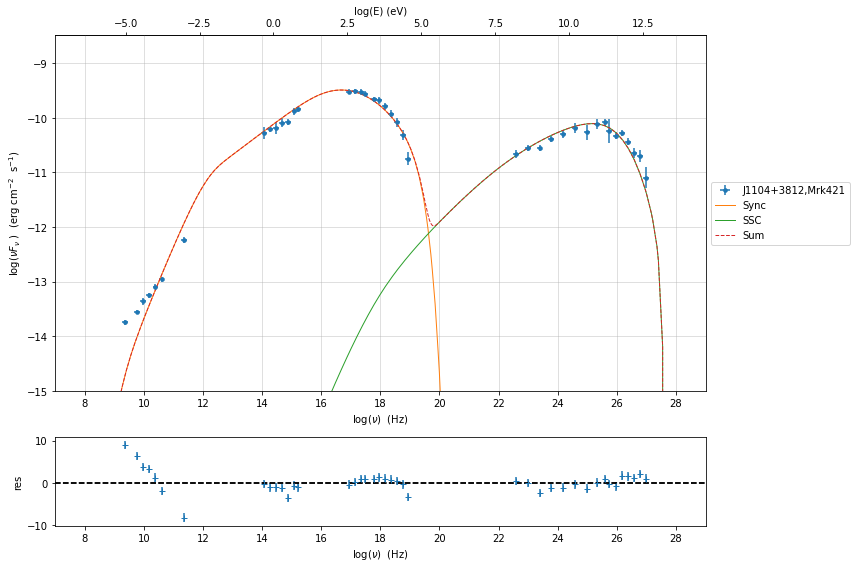

In [10]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

## Model fitting only Synchorotron component

### Model fitting with Minuit

In [11]:
from jetset.jet_model import Jet
jet_minuit=Jet.load_model('prefit_jet.pkl')
jet_minuit.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060843e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


we switch off the IC component

In [12]:

jet_minuit.spectral_components.SSC.state='off'
jet_minuit.show_model()


--------------------------------------------------------------------------------
jet model description
--------------------------------------------------------------------------------
name: jet_leptonic  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 4.697542e+02
 gmax grid : 1.373160e+06
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: on
   name:Sync, state: self-abs
   name:SSC, state: off
external fields transformation method: blob

SED info:
 nu grid size jetkernel: 1000
 nu grid size: 500
 nu mix (Hz): 1.000000e+06
 nu max (Hz): 1.000000e+30

flux plot lower bound   :  1.000000e-120

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060843e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


--------------------------------------------------------------------------------


In [13]:
fit_model_minuit=FitModel( jet=jet_minuit, name='Only-Synch-best-fit-minuit') 

fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.freeze('jet_leptonic','R')
fit_model_minuit.freeze('jet_leptonic','gmax')
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[10**15.5, 10**17.5]
fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]

In [14]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10.0**15,10**20.0,fitname='SSC-best-fit-minuit',repeat=3)

filtering data in fit range = [1.000000e+15,1.000000e+20]
data length 13

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=1.36485e+00
fit run: 1
- old chisq=1.36485e+00


0it [00:00, ?it/s]


- best chisq=1.36484e+00
fit run: 2
- old chisq=1.36484e+00


0it [00:00, ?it/s]


- best chisq=1.36484e+00
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,9.154181e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,True
jet_leptonic,N,emitters_density,1 / cm3,1.849784e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.337702e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.159100e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,6.038064e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,True
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,2.090792e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.326479e+01,1.000000e-04,--,False,False



converged=True
calls=101
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.365                      │       Ncalls = 101 (101 total)       │
│ EDM = 6.96e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │  0.92e3   │  0.27e3   │            │            │    1    │  1e+09  │       │
│ 1 │ par_1 │    1.8    │    0.6    │            │            │    0    │         │       │
│ 2 │ par_2 │   43e3    │    9e3    │            │            │    1    │  1e+09  │       │
│ 3 │ par_3 │   2.16    │   0.06    │            │            │   -10   │   10    │       │
│ 4 │ par_4 │   0.60    │   0.08    │            │            │   -15   │   15    │       │
│ 5 │ par_5 │  0.0209   │  0.0024   │            │            │    0    │         │       │
│ 6 │ par_6 │   23.3    │    1.8    │            │            │    5    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=6
chisq=1.364839, chisq/red=0.227473 null hypothesis sig=0.967962

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,9.154181e+02,9.154181e+02,2.678220e+02,--,4.697542e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.373160e+06,--,--,--,1.373160e+06,1.000000e+00,1.000000e+15,True
jet_leptonic,N,1.849784e+00,1.849784e+00,5.688406e-01,--,9.060843e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.337702e+04,4.337702e+04,9.156630e+03,--,3.188500e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.159100e+00,2.159100e+00,6.232797e-02,--,2.181578e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,6.038064e-01,6.038064e-01,8.026771e-02,--,7.726502e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.112712e+16,--,--,--,3.112712e+16,3.162278e+15,3.162278e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,2.090792e-02,2.090792e-02,2.436512e-03,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,2.326479e+01,2.326479e+01,1.759682e+00,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




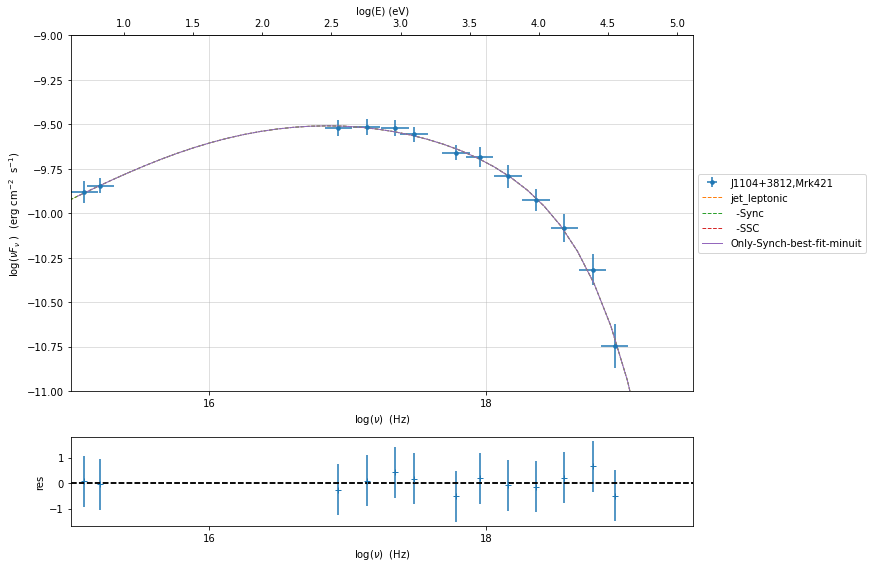

In [18]:
%matplotlib inline
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.rescale(y_min=-11,x_min=15,y_max=-9,x_max=19.5)

In [19]:
model_minimizer_minuit.minimizer.mesg

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.365                      │       Ncalls = 101 (101 total)       │
│ EDM = 6.96e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │  0.92e3   │  0.27e3   │            │            │    1    │  1e+09  │       │
│ 1 │ par_1 │    1.8    │    0.6    │            │            │    0    │         │       │
│ 2 │ par_2 │   43e3    │    9e3    │            │            │    1    │  1e+09  │       │
│ 3 │ par_3 │   2.16    │   0.06    │            │            │   -10   │   10    │       │
│ 4 │ par_4 │   0.60    │   0.08    │            │            │   -15   │   15    │       │
│ 5 │ par_5 │  0.0209   │  0.0024   │            │            │    0    │         │       │
│ 6 │ par_6 │   23.3    │    1.8    │            │            │    5    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

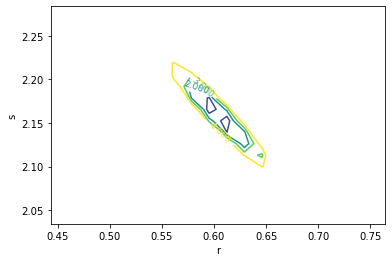

In [20]:
c=model_minimizer_minuit.minimizer.draw_contour('r','s')

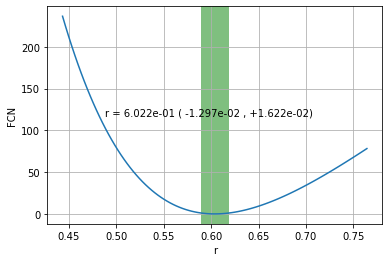

In [21]:
m=model_minimizer_minuit.minimizer.draw_profile('r')

In [22]:
best_fit_minuit.save_report('SSC-best-fit-minuit.txt')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

## MCMC sampling

In [23]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used


In [24]:
model_minimizer_minuit = ModelMinimizer.load_model('model_minimizer_minuit.pkl')

mcmc=McmcSampler(model_minimizer_minuit)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 272.70 seconds


In [25]:
print(mcmc.acceptance_fraction)

0.5203125000000001


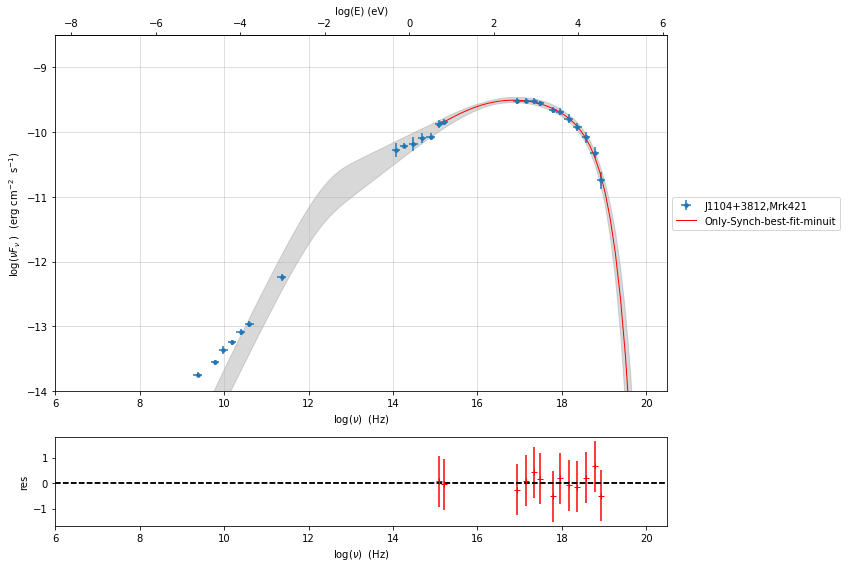

In [26]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[15., 20.],size=50)
p.rescale(y_min=-14,x_min=6,x_max=20.5)

f=mcmc.plot_chain('s',log_plot=False)

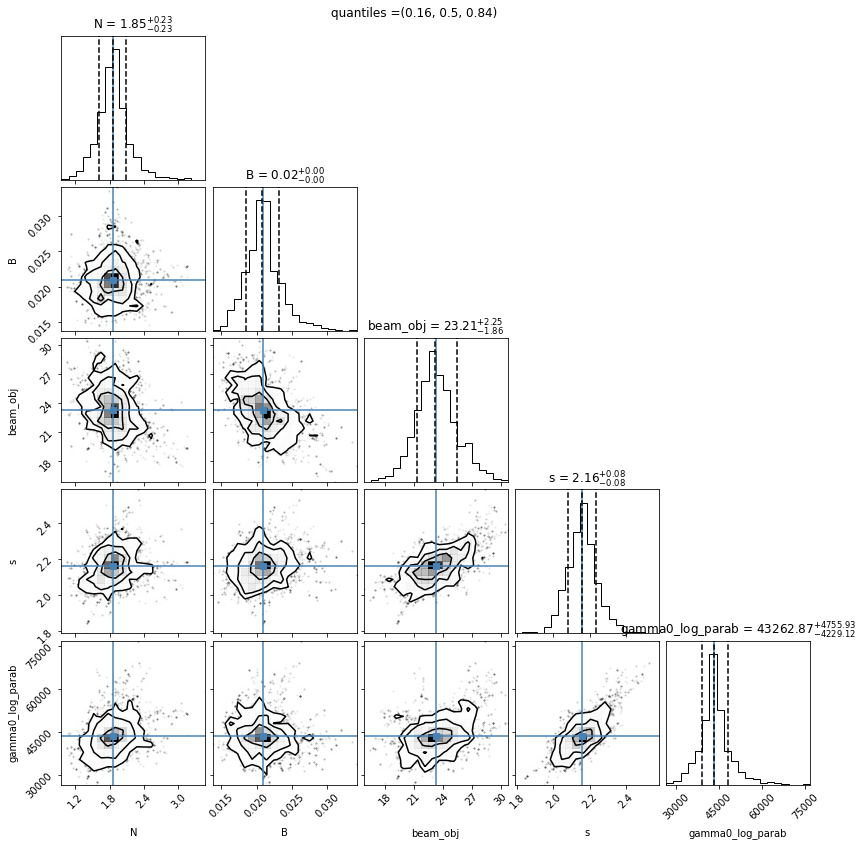

In [27]:
f=mcmc.corner_plot()

In [28]:
mcmc.get_par('N')

(array([1.8651072 , 1.88091994, 1.89558327, ..., 1.73653062, 2.48095847,
        1.646841  ]),
 0)

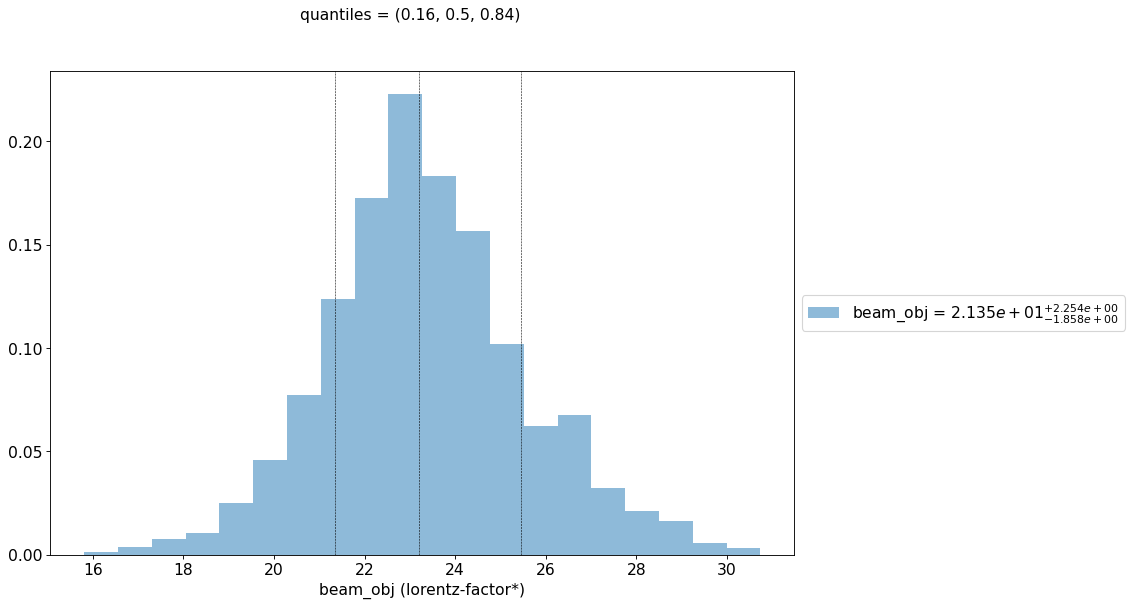

In [29]:
f=mcmc.plot_par('beam_obj')

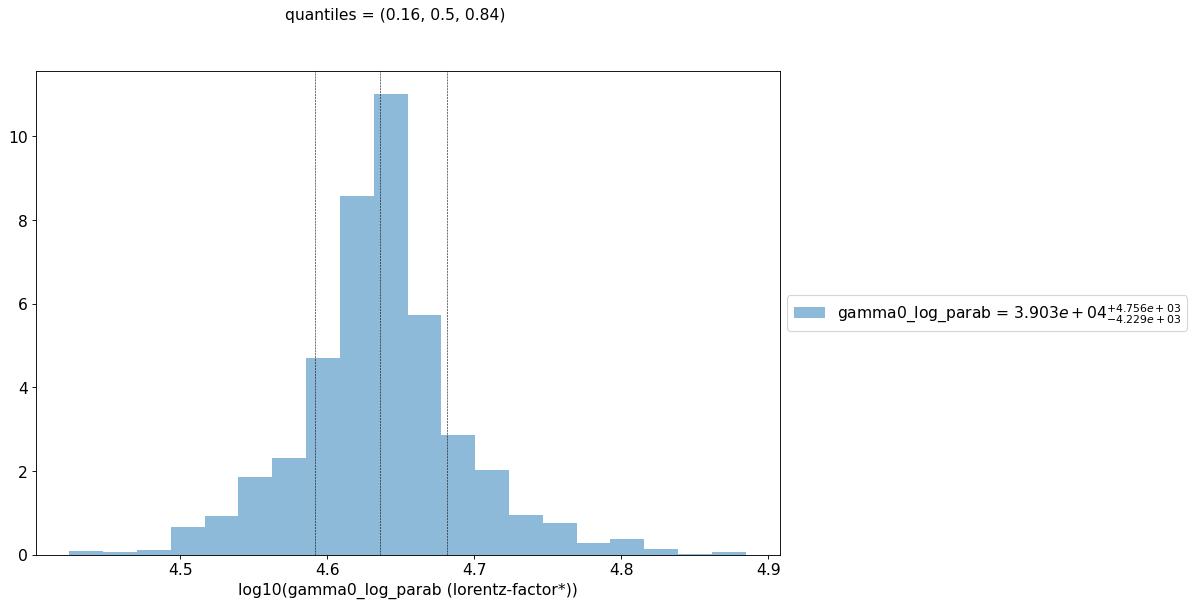

In [30]:
f=mcmc.plot_par('gamma0_log_parab',log_plot=True)

## Save and reuse MCMC

In [31]:
mcmc.save('mcmc_sampler.pkl')

In [32]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_401.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

In [33]:
ms.model.name

'Only-Synch-best-fit-minuit'

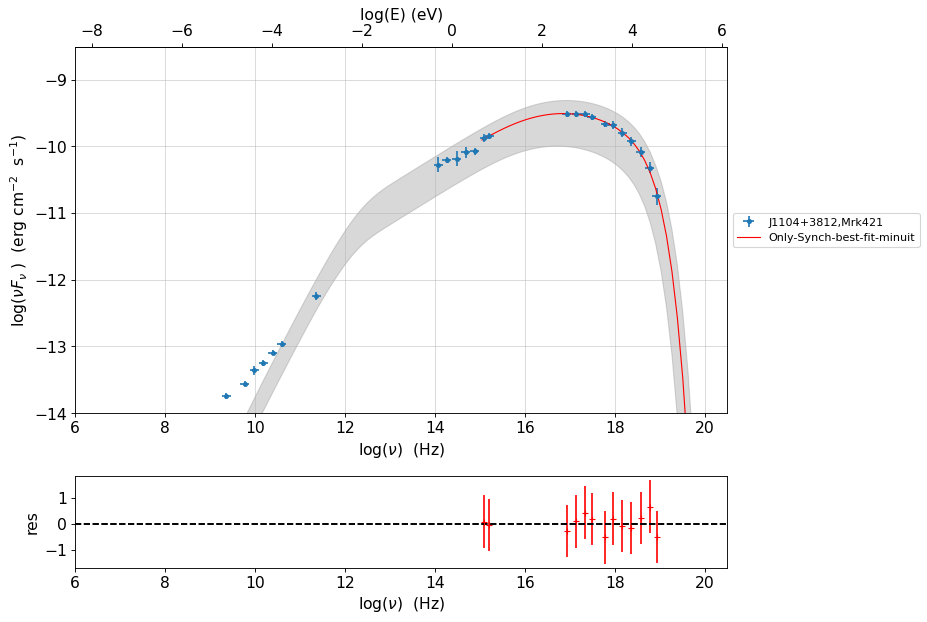

In [34]:
p=ms.plot_model(sed_data=sed_data,fit_range=[15., 20.],size=50)
p.rescale(y_min=-14,x_min=6,x_max=20.5)

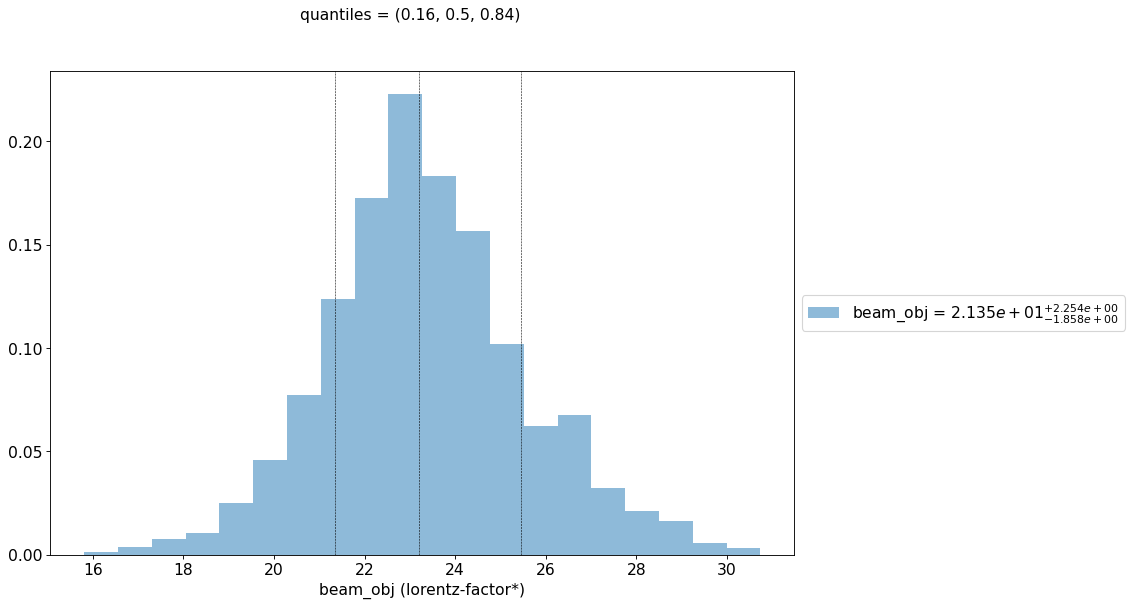

In [35]:
f=ms.plot_par('beam_obj',log_plot=False)


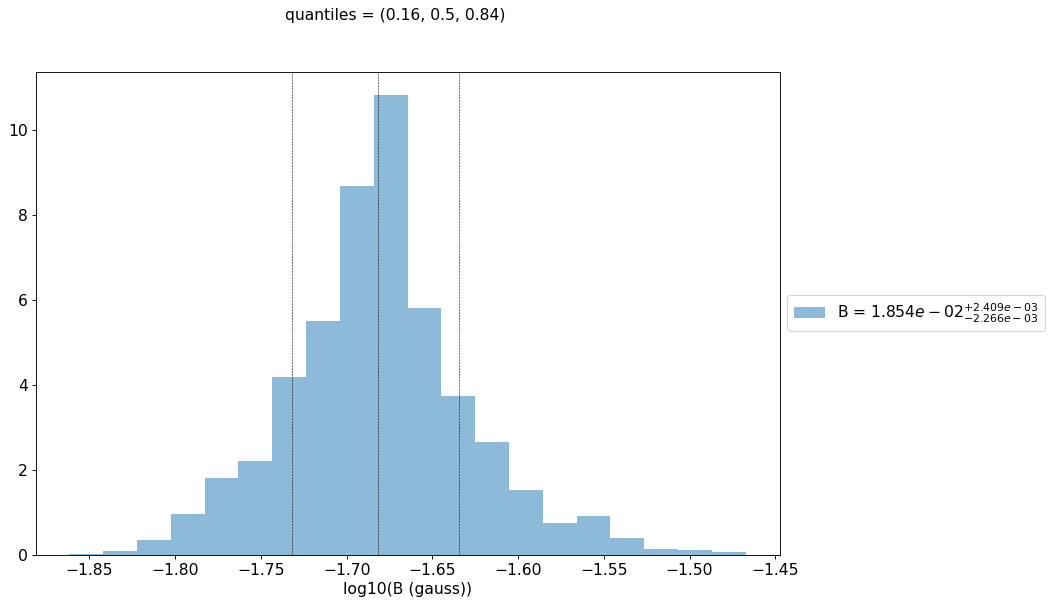

In [36]:
f=ms.plot_par('B',log_plot=True)


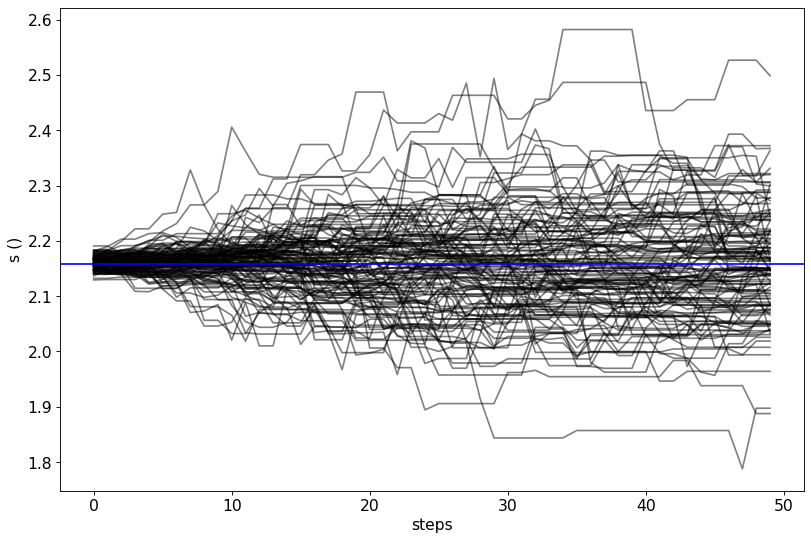

In [37]:
f=mcmc.plot_chain('s',log_plot=False)

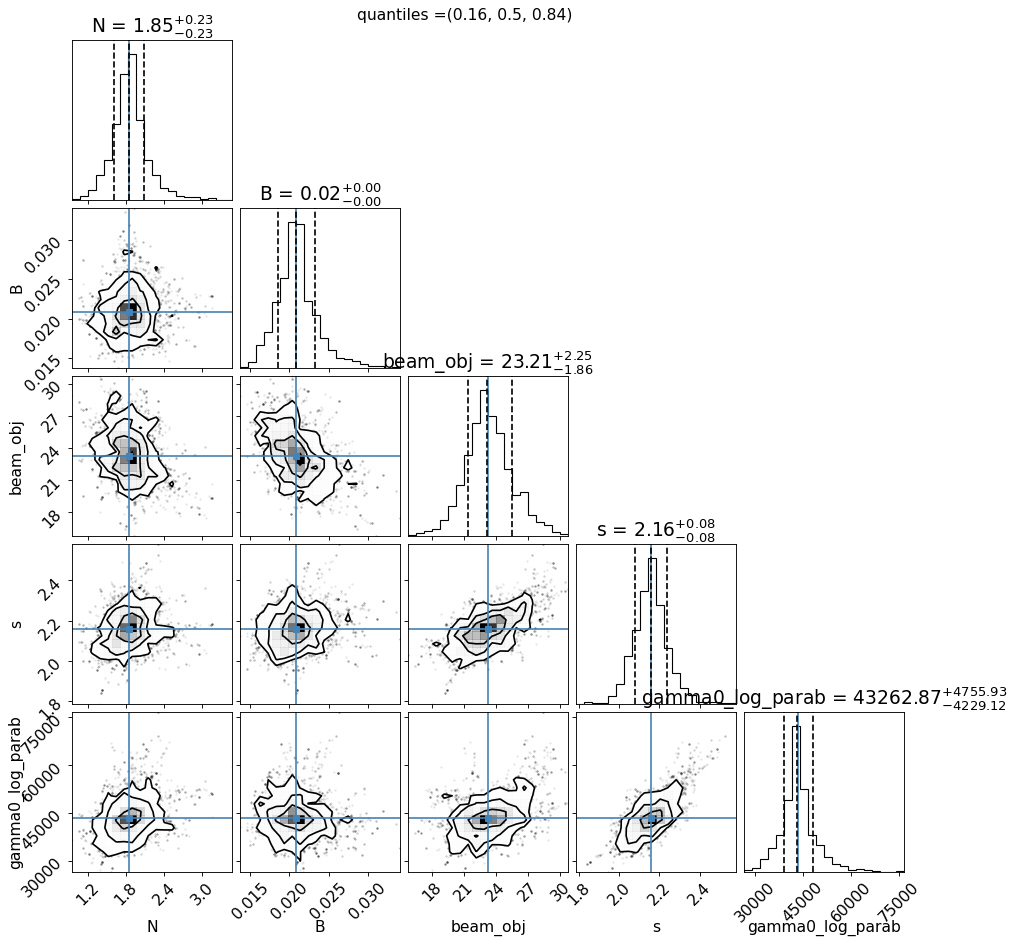

In [38]:
f=mcmc.corner_plot()